# 가위바위보 분류기를 만들자

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image
import glob

### matplotlib
- 파이썬에서 제공하는 시각화(Visualization) 라이브러리로 이 프로젝트에서는 training 이미지의 resize가 잘 이루어졌는지 확인하기 위해 사용된다
---
### os
- 운영체제에서 제공되는 여러기능을 파이썬에서 사용할 수 있도록 하는 모듈로 현재 작업하고 있는 디렉토리의 경로를 얻는다
---
### PIL
- 다양한 이미지 파일 형식을 지원하고 강력한 이미지 처리와 그래픽 기능을 제공하는 라이브러리로 이 프로젝트에서는 데이터 이미지의 크기를 줄이기 위해 사용된다
---
### glob
- 파일들의 리스트를 뽑을 때 사용된다

## (1) training set 만들기

### resize_images()
- 224x224 사이즈의 이미지를 28x28 사이즈의 이미지로 변환
- ANTIALIAS : 안티엘리어싱은 한국어로 위신호 제거라는 용어로 높은 해상도의 사진 또는 영상을 낮은 해상도로 변환하거나 나타낼때 깨진 패턴의 형태로 나타나게 되는데 이를 최소화 시켜주는 방법

In [2]:
def resize_images(img_path):
    images=glob.glob(img_path + "/*.jpg")  
    
    print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
    target_size=(28,28)
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS)
        new_img.save(img, "JPEG")
    
    print(len(images), " images resized.")

In [3]:
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/scissor1"
resize_images(image_dir_path)

print("가위 이미지 resize 완료!")
print(" ")

# 바위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/rock1"
resize_images(image_dir_path)

print("바위 이미지 resize 완료")
print(" ")

# 보 이미지 변환

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/paper1"
resize_images(image_dir_path)

print("보 이미지 resize 완료!")
print(" ")

1500  images to be resized.
1500  images resized.
가위 이미지 resize 완료!
 
1500  images to be resized.
1500  images resized.
바위 이미지 resize 완료
 
1500  images to be resized.
1500  images resized.
보 이미지 resize 완료!
 


### load_data()
- numpy를 이용해서 이미지 데이터와 라벨을 행렬에 저장
- dtype=np.int32 : 정수 단일 값을 32bits 메모리에 저장

In [4]:
import numpy as np

def load_data(img_path, number_of_data=4500):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor1/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock1/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper1/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 4500 입니다.
x_train shape: (4500, 28, 28, 3)
y_train shape: (4500,)


### 이미지와 라벨 확인

라벨:  0


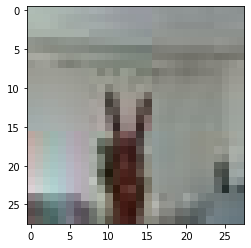

In [5]:
# 확인
plt.imshow(x_train[15])
print('라벨: ', y_train[15])

## (2) 딥러닝 네트워크 설계

###  LeNet
- tf.keras의 Sequential API를 이용한 딥러닝 네트워크
- Conv2D 레이어
    - 첫 번째 인자: 사용하는 이미지 특징의 수. 여기서는 가장 먼저 32개의 이미지 특성을, 그 뒤에는 64개의 이미지 특징을 고려
    - 두 번째 인자: 컨볼루션 커널의 (행,열)
    - activation : 활성화 함수 설정. 여기서는 'relu' 함수가 쓰였다
- Dense 레이어
    - 첫 번째 인자: 분류기에 사용되는 뉴런의 숫자. 이 값이 클수록 보다 복잡한 분류기를 만들 수 있다
- 마지막 Dense 레이어
    - 뉴런 숫자는 결과적으로 분류해 내야 하는 클래스 수로 여기서는 3(가위,바위,보)

In [6]:
n_channel_1=32
n_channel_2=64

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                102464    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1

## (3) 딥러닝 네트워크 학습

In [8]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train_norm, y_train, epochs=10)  

Epoch 1/10
141/141 [==============================] - 3s 4ms/step - loss: 1.0589 - accuracy: 0.4700
Epoch 2/10
141/141 [==============================] - 0s 3ms/step - loss: 0.6315 - accuracy: 0.7542
Epoch 3/10
141/141 [==============================] - 0s 3ms/step - loss: 0.3737 - accuracy: 0.8764
Epoch 4/10
141/141 [==============================] - 0s 3ms/step - loss: 0.2318 - accuracy: 0.9327
Epoch 5/10
141/141 [==============================] - 0s 3ms/step - loss: 0.1646 - accuracy: 0.9518
Epoch 6/10
141/141 [==============================] - 0s 3ms/step - loss: 0.1183 - accuracy: 0.9667
Epoch 7/10
141/141 [==============================] - 0s 3ms/step - loss: 0.0853 - accuracy: 0.9778
Epoch 8/10
141/141 [==============================] - 0s 3ms/step - loss: 0.0643 - accuracy: 0.9833
Epoch 9/10
141/141 [==============================] - 0s 3ms/step - loss: 0.0455 - accuracy: 0.9889
Epoch 10/10
141/141 [==============================] - 0s 3ms/step - loss: 0.0348 - accuracy: 0.9922

## (4) test set 만들기

In [9]:
# 가위 테스트 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test2/scissor"
resize_images(image_dir_path)

print("가위 테스트 이미지 resize 완료!")
print(" ")

# 바위 테스트 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test2/rock"
resize_images(image_dir_path)

print("바위 테스트 이미지 resize 완료!")
print(" ")

# 보 테스트 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test2/paper"
resize_images(image_dir_path)

print("보 테스트 이미지 resize 완료!")

100  images to be resized.
100  images resized.
가위 테스트 이미지 resize 완료!
 
100  images to be resized.
100  images resized.
바위 테스트 이미지 resize 완료!
 
100  images to be resized.
100  images resized.
보 테스트 이미지 resize 완료!


In [10]:
def load_data(img_path, number_of_data=300):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("테스트데이터(x_test)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test2"
(x_test, y_test)=load_data(image_dir_path)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

테스트데이터(x_test)의 이미지 개수는 300 입니다.
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)


## (5) Accuracy 측정

In [11]:
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

10/10 - 0s - loss: 2.1816 - accuracy: 0.7300
test_loss: 2.1816039085388184 
test_accuracy: 0.7300000190734863


## (6) 고찰

### 결과

- 훈련 데이터 4500개로 이미지 분류기 모델을 만들고 테스트 데이터 300개로 테스트를 한 결과 test accuracy가 약 0.73이 나왔다
- 하지만 test loss가 2.18이 나온 것은 꽤 많이 나온 값인데 이는 모델이 너무 복잡해서 과대적합(Overfitting)이 발생한 걸로 보인다.
    - 과대적합 : epoch가 진행되면서 train loss는 계속 감소하지만 test loss가 증가하기 시작함. 모델이 너무 복잡하면 발생하고 좀 더 단순한 모델을 사용하는 것을 생각해 봐야 함. 훈련 데이터에 특화된 패턴을 학습하기 시작하여 새로운 데이터에 대해 잘못된 판단을 함
    - 과대적합을 방지하기 위한 방법
        - 더 많은 data를 수집
        - 모델을 간단하게 바꾼다
- 과대적합을 해결하기 위하여 네트워크의 하이퍼파라미터를 n_channel_1=16, n_channel_2=32, Dense의 뉴런 개수=32로 변경하였다.
- 변경한 후 결과는 test_loss = 1.55508, test_accuracy = 0.6777으로 test loss는 감소하였지만 test accuracy는 조금 감소했다


---
### 과정

1. train data : 900 / test data : 300 / n_chann1_1 : 16 / n_channel_2 : 32 일 때 0.33
2. train data : 900 / test data : 300 / n_chann1_1 : 64 / n_channel_2 : 128 일 때 0.36
3. train data : 900 / test data : 300 / n_chann1_1 : 128 / n_channel_2 : 256 일 때 0.31
- 하이퍼파라미터의 문제가 아닌것 같아서 데이터의 양을 늘려보았다
4. train data : 3138 / test data : 300 / n_channel_1 : 32 / n_channel_2 : 64 일 때 0.33
5. train data : 3138 / test data : 300 / n_channel_1 : 128 / n_channel_2 : 256 일 때 0.43
- 데이터의 양을 늘려도 개선이 되지 않아서 데이터의 질을 바꾸려고 노력했다. 정확하게 찍힌 사진들로 선정하여 데이터의 질을 좀 더 높이고 양을 조금 늘렸다
6. train data : 4500 / test data : 300 / n_channel_1 : 32 / n_channel_2 : 64 드디어 0.73!

---

### 정리
- 데이터의 질이 중요하다고 생각이 들었다. 아무리 많은 양의 데이터가 있어도 도움이 되지 못하는 데이터라면 양이 많은게 좋은게 아니다.
- 사진마다 배경과 빛 등 다양한 부분에서 차이가 있는데 이런 부분들도 학습이 됐기 때문에 과대적합이 발생한 것 같다 
- 테스트할게 많아도 정확도가 떨어진다
- 하이퍼파라미터가 너무 커도 너무 많은 특징을 잡아서 좋지 않다
- resize를 왜 할까 생각했는데 이미지 사이즈가 크면 학습시간이 오래걸리고 기대했던 것 보다 정확도가 좋지 않았다 
- Conv2D레이어와 Maxpooling2D 레이어를 추가하면 정확도가 더 올라간다고 해서 한 쌍, 두 쌍 점점 추가를 해보았지만 너무 많이 추가했을 경우에 오히려 정확도가 떨어졌다. 이 부분은 공부를 더 해야할 것 같다